In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import numpy as np
import jax.numpy as jnp

import seaborn as sns
sns.set_context('paper', font_scale = 1.5)
sns.color_palette('colorblind')

import h5py

import corner

#for calculating rates from GC models
import GC_rates

In [2]:
GC_data = GC_rates.read_data()

R_dyn(z) inferred from GWTC-3, from chieff-evolution-fitting.ipynb

In [3]:
with h5py.File('GW_dynrate_z0_z1.h5', 'r') as inp:
    GW_R0_post = np.array(inp['dyn_rate_z0'])
    GW_R1_post = np.array(inp['dyn_rate_z1'])
    
with h5py.File('GW_dynrate_versus_z.h5', 'r') as inp:
    dyn_rate = np.array(inp['dyn_rate'])
    z_plot = np.array(inp['z'])
    total_rate = np.array(inp['total_rate'])

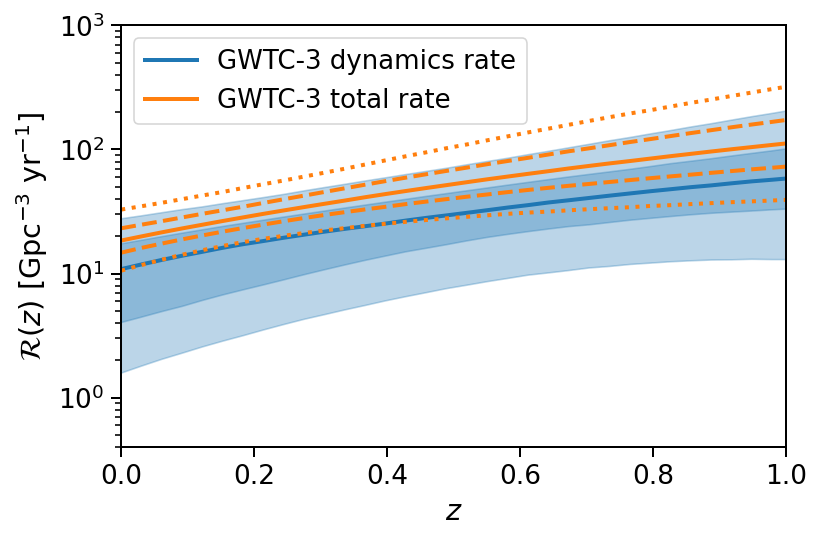

In [4]:
plt.plot(z_plot, np.percentile(dyn_rate, 50, axis = 0), label = 'GWTC-3 dynamics rate', linewidth = 2.0)
plt.fill_between(z_plot, np.percentile(dyn_rate, 5, axis = 0), np.percentile(dyn_rate, 95, axis = 0), alpha = 0.3, color = sns.color_palette()[0])
plt.fill_between(z_plot, np.percentile(dyn_rate, 25, axis = 0), np.percentile(dyn_rate, 75, axis = 0), alpha = 0.3, color = sns.color_palette()[0])

plt.plot(z_plot, np.percentile(total_rate, 50, axis = 0), label = 'GWTC-3 total rate', linewidth = 2.0, color = sns.color_palette()[1])
plt.plot(z_plot, np.percentile(total_rate, 5, axis = 0), color = sns.color_palette()[1], ls = ':', linewidth = 2.0)
plt.plot(z_plot, np.percentile(total_rate, 95, axis = 0), color = sns.color_palette()[1], ls = ':', linewidth = 2.0)
plt.plot(z_plot, np.percentile(total_rate, 25, axis = 0), color = sns.color_palette()[1], ls = '--', linewidth = 2.0)
plt.plot(z_plot, np.percentile(total_rate, 75, axis = 0), color = sns.color_palette()[1], ls = '--', linewidth = 2.0)


plt.yscale('log')
plt.ylim(4e-1,1e3)
plt.xlim(min(z_plot), 1)

plt.xlabel(r'$z$')
plt.ylabel(r'$\mathcal{R}(z)$ [Gpc$^{-3}$ yr$^{-1}$]')
plt.legend(loc = 'upper left', fontsize = 13)

plt.tight_layout()
plt.savefig('GWTC3_dynamicsrate_totalrate.pdf')

In [5]:
def plot_cluster_rate(zmin, zmax, dz = 0.2, z_gc = 4, a = 3, b = 5, sigma_dex = 0.5, Zsun = 0.02,
                     mu_rv = 1.5, sigma_rv = 1.5, beta = -2, logMstar0 = 6.3, dNdV0 = 2.31e9,
                     logf_disrupted_cluster = 1, logMlo = 4, logMhi = 8, plot_formation = False, plot_form_kwargs = {}, plot_kwargs = {}):
    z_c = np.arange(zmin, zmax + dz, step = dz)
    R_z_c = [GC_rates.merger_rate_at_z_pop(
        GC_data, z, z_gc, a, b, dNdV0, logf_disrupted_cluster, sigma_dex, Zsun, mu_rv, sigma_rv, 
        beta, logMstar0, logMlo, logMhi) for z in z_c]
        
    plt.plot(z_c, R_z_c, **plot_kwargs)
    
    if plot_formation:
        R_z_form = [GC_rates.sfr_at_z(zi, dNdV0, z_gc, a, b, 10**logf_disrupted_cluster) for zi in z_c]
        plt.plot(z_c, np.array(R_z_form), **plot_form_kwargs)
        
    plt.xlabel(r'redshift $z$')
    plt.xlim(zmin, zmax)
    plt.ylabel(r'$\mathcal{R}(z)$ [Gpc$^{-3}$ yr$^{-1}$]')
    plt.yscale('log')

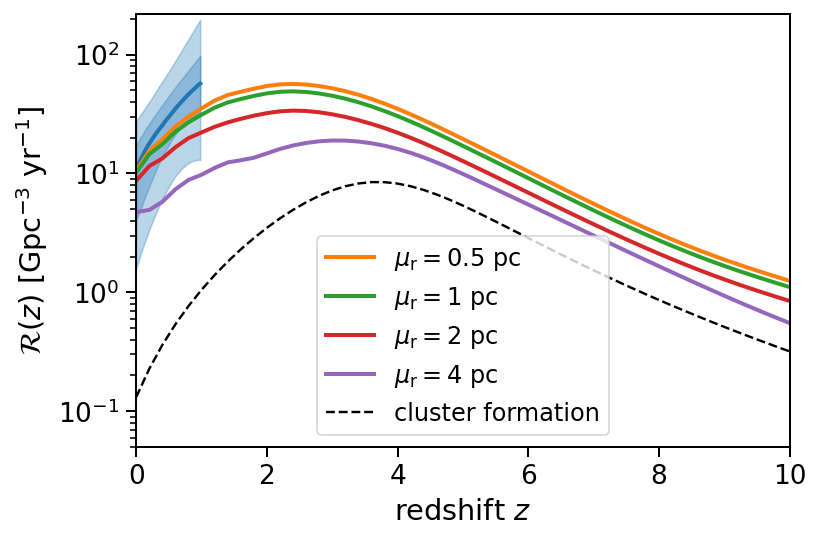

In [6]:
plt.plot(z_plot[z_plot < 1], np.percentile(dyn_rate, 50, axis = 0)[z_plot < 1], linewidth = 2.0)
plt.fill_between(z_plot[z_plot < 1], np.percentile(dyn_rate, 5, axis = 0)[z_plot < 1], np.percentile(dyn_rate, 95, axis = 0)[z_plot < 1], alpha = 0.3, color = sns.color_palette()[0])
plt.fill_between(z_plot[z_plot < 1], np.percentile(dyn_rate, 25, axis = 0)[z_plot < 1], np.percentile(dyn_rate, 75, axis = 0)[z_plot < 1], alpha = 0.3, color = sns.color_palette()[0])

plot_cluster_rate(0, 20, mu_rv = 0.5, sigma_rv = 1, plot_kwargs = dict(label = r'$\mu_\mathrm{r} = 0.5$ pc', color = sns.color_palette()[1], linewidth = 2))

plot_cluster_rate(0, 20, mu_rv = 1, sigma_rv = 1, plot_kwargs = dict(label = r'$\mu_\mathrm{r} = 1$ pc', color = sns.color_palette()[2], linewidth = 2))

plot_cluster_rate(0, 20, mu_rv = 2, sigma_rv = 1, plot_kwargs = dict(label = r'$\mu_\mathrm{r} = 2$ pc', color = sns.color_palette()[3], linewidth = 2))

plot_cluster_rate(0, 20, mu_rv = 4, sigma_rv = 1, plot_formation = True, plot_form_kwargs = dict(label = r'cluster formation', ls = '--', c = 'k'), plot_kwargs = dict(label = r'$\mu_\mathrm{r} = 4$ pc', linewidth = 2, color = sns.color_palette()[4]))

plt.xlim(0,10)
plt.ylim(5e-2,2.2e2)

plt.legend(loc = 'lower center', fontsize = 12)
#~10 mergers per cluster for clusters in this mass range

plt.tight_layout()
plt.savefig('GWTC3_dynamicsrate_with_GCpred_mu-r.pdf')

### Inference of cluster properties

starting with formation rate

In [7]:
sigma_dex = 0.5 #spread in metallicity distribution at each redshift
Zsun = 0.02 #solar metallicity
logMlo = 4 #minimum GC mass is 10^8 Msun
logMhi = 8 #maximum GC mass is 10^8 Msun
dNdV0 = 2.31e9 #number density of evolved clusters *today* in Gpc^-3

samples = {}
with h5py.File('GC_properties_fixedmassdist.h5', 'r') as inp:
    for n in inp.keys():
        samples[n] = np.array(inp[n])

In [8]:
samples.keys()

dict_keys(['a', 'b', 'beta', 'logMstar0', 'logf_disrupted_cluster', 'mu_rv', 'sigma_rv', 'z_gc'])

In [9]:
nsamps = 500 #store nsamps posterior draws

zs = np.linspace(0, 20, 50) #redshift grid

Rgc_z = np.zeros((len(zs), nsamps)) #to store posterior draws of formation rate density of globular clusters as a function of redshift

for j, i in enumerate(np.random.choice(len(samples['z_gc']), size = nsamps, replace = False)):
    Rgc_z[:, j] = np.array([GC_rates.sfr_at_z(zi, dNdV0, samples['z_gc'][i], samples['a'][i], samples['b'][i], 10**samples['logf_disrupted_cluster'][i]) for zi in zs])


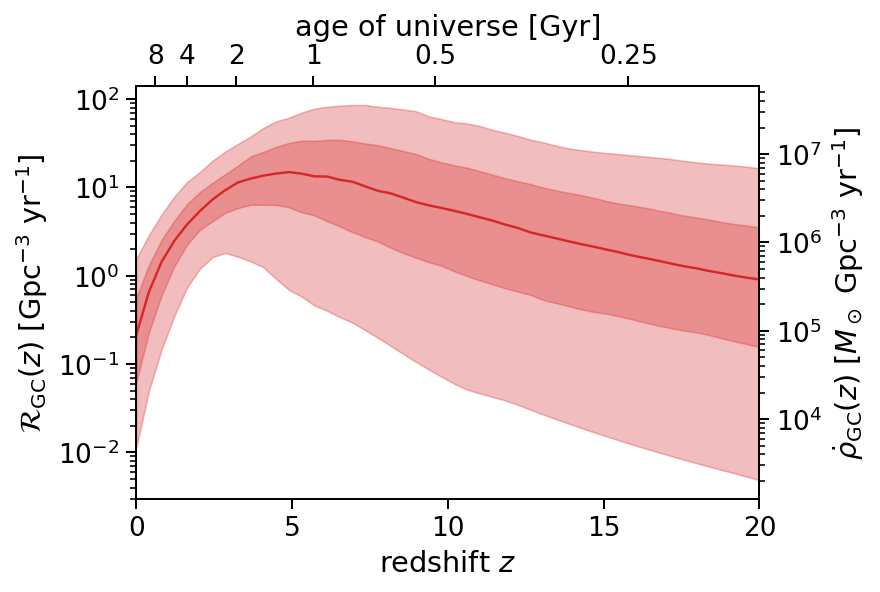

In [21]:
fig, ax = plt.subplots(constrained_layout=True)

ax.plot(zs, np.percentile(Rgc_z, 50, axis = -1), color = sns.color_palette()[3])
ax.fill_between(zs, np.percentile(Rgc_z, 5, axis = -1), np.percentile(Rgc_z, 95, axis = -1), alpha = 0.3, color = sns.color_palette()[3])
ax.fill_between(zs, np.percentile(Rgc_z, 25, axis = -1), np.percentile(Rgc_z, 75, axis = -1), alpha = 0.3, color = sns.color_palette()[3])

ax.set_xlabel(r'redshift $z$')
ax.set_ylabel(r'$\mathcal{R}_\mathrm{GC}(z)$ [Gpc$^{-3}$ yr$^{-1}$]')

ax.set_xlim(min(zs), max(zs))
ax.set_yscale('log')

from astropy.cosmology import Planck15
from astropy import units as u
ages = Planck15.age(zs).to(u.Gyr).value
def ztoage(z):
    return np.interp(z, zs, ages)
def agetoz(t):
    return np.interp(t, ages[::-1], zs[::-1])

average_cluster_mass = GC_rates.average_mass_schechter(beta = samples['beta'][0], logMstar0 = samples['logMstar0'][0], logMlo = logMlo, logMhi = logMhi, res = 100)
def rate_to_mass(rate):
    return rate * average_cluster_mass

def mass_to_rate(mass):
    return mass / average_cluster_mass

timeax = ax.secondary_xaxis('top', functions=(ztoage, agetoz))
timeax.set_xticks(ticks = [0.25, 0.5, 1, 2, 4, 8], labels = ['0.25', '0.5', '1', '2', '4', '8'])
timeax.set_xlabel('age of universe [Gyr]')

massax = ax.secondary_yaxis('right', functions = (rate_to_mass, mass_to_rate))
massax.set_ylabel(r'$\dot{\rho}_\mathrm{GC}(z)$ [$M_\odot$ Gpc$^{-3}$ yr$^{-1}$]')

plt.savefig('GCformation_numberdensity_vsredshift_posterior.pdf')

In [22]:
np.log10(average_cluster_mass)

5.623343

now the radius distribution

In [23]:
nsamps = 500

rs = np.array([0.5, 1, 2, 4]) #radius grid, same as grid of GC models
dr_grid = np.array([0.5, 0.5, 1, 2]) #dr, assuming first "bin" starts at 0 (for plotting purposes)

p_radius = np.zeros((len(rs), nsamps)) #to store posterior draws of pdf(radius)

dNdVdTdR_z2 = np.zeros_like(p_radius) #to store posterior draws of (GC formation density at z = 2) * p(R)

rand_ind = np.random.choice(len(samples['z_gc']), size = nsamps, replace = False)

for j, i in enumerate(rand_ind):
    
    p_radius[:, j] = np.array([GC_rates.radius_weights(r, samples['mu_rv'][i], samples['sigma_rv'][i]) for r in rs])/dr_grid
    
    dNdVdT_z2 = GC_rates.sfr_at_z(2, dNdV0, samples['z_gc'][i], samples['a'][i], samples['b'][i], 10**samples['logf_disrupted_cluster'][i])
    dNdVdTdR_z2[:, j] = p_radius[:, j] * dNdVdT_z2

(0.0, 0.6)

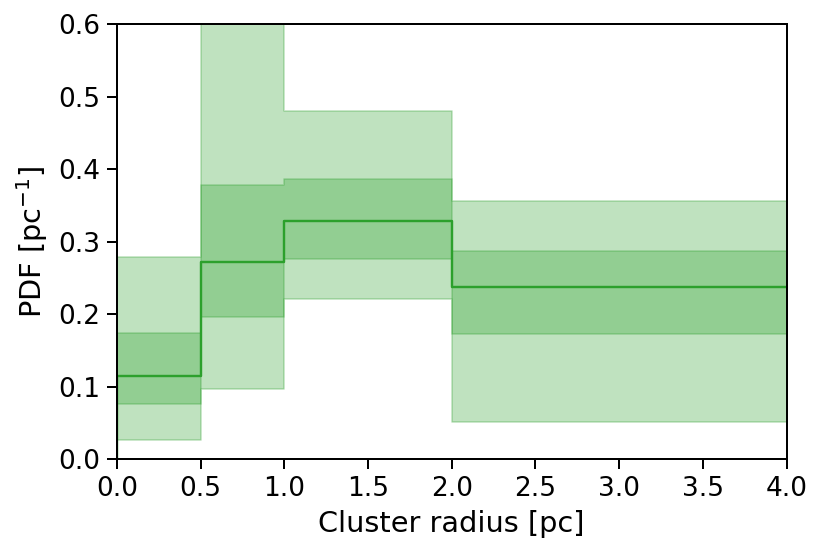

In [24]:
plt.step(np.append(0, rs), np.append(0, np.percentile(p_radius, 50, axis = -1)), color = sns.color_palette()[2], where = 'pre')
plt.fill_between(np.append(0, rs), np.append(0, np.percentile(p_radius, 5, axis = -1)), np.append(0, np.percentile(p_radius, 95, axis = -1)), alpha = 0.3, step = 'pre', color = sns.color_palette()[2])
plt.fill_between(np.append(0, rs), np.append(0, np.percentile(p_radius, 25, axis = -1)), np.append(0, np.percentile(p_radius, 75, axis = -1)), alpha = 0.3, step = 'pre', color = sns.color_palette()[2])

plt.xlabel('Cluster radius [pc]')
plt.ylabel(r'PDF [pc$^{-1}$]')

plt.xlim(0, 4)
plt.ylim(0,0.6)

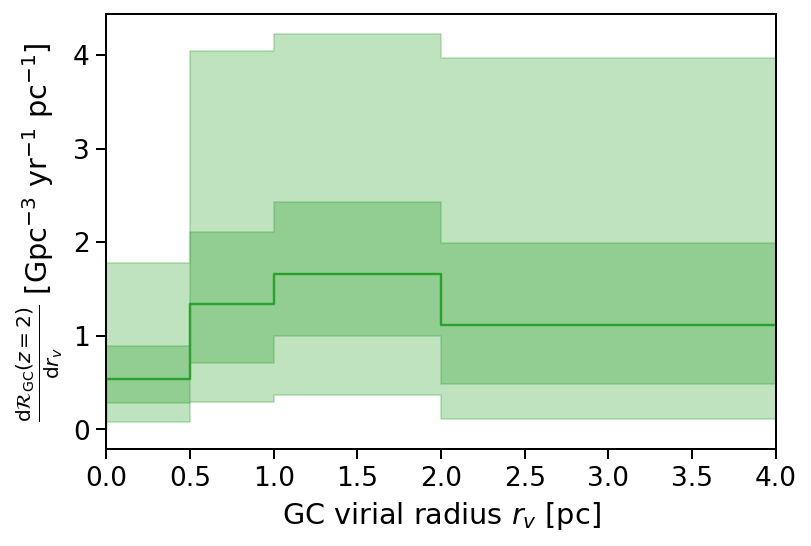

In [26]:
plt.step(np.append(0, rs), np.append(0, np.percentile(dNdVdTdR_z2, 50, axis = -1)), color = sns.color_palette()[2], where = 'pre')
plt.fill_between(np.append(0, rs), np.append(0, np.percentile(dNdVdTdR_z2, 5, axis = -1)), np.append(0, np.percentile(dNdVdTdR_z2, 95, axis = -1)), alpha = 0.3, step = 'pre', color = sns.color_palette()[2])
plt.fill_between(np.append(0, rs), np.append(0, np.percentile(dNdVdTdR_z2, 25, axis = -1)), np.append(0, np.percentile(dNdVdTdR_z2, 75, axis = -1)), alpha = 0.3, step = 'pre', color = sns.color_palette()[2])

plt.xlabel(r'GC virial radius $r_v$ [pc]')
plt.ylabel(r'$\frac{\mathrm{d}\mathcal{R}_\mathrm{GC}(z = 2)}{\mathrm{d}r_v}$ [Gpc$^{-3}$ yr$^{-1}$ pc$^{-1}$]')

plt.xlim(0, 4)

plt.savefig('GCradius_distribution_posterior.pdf')

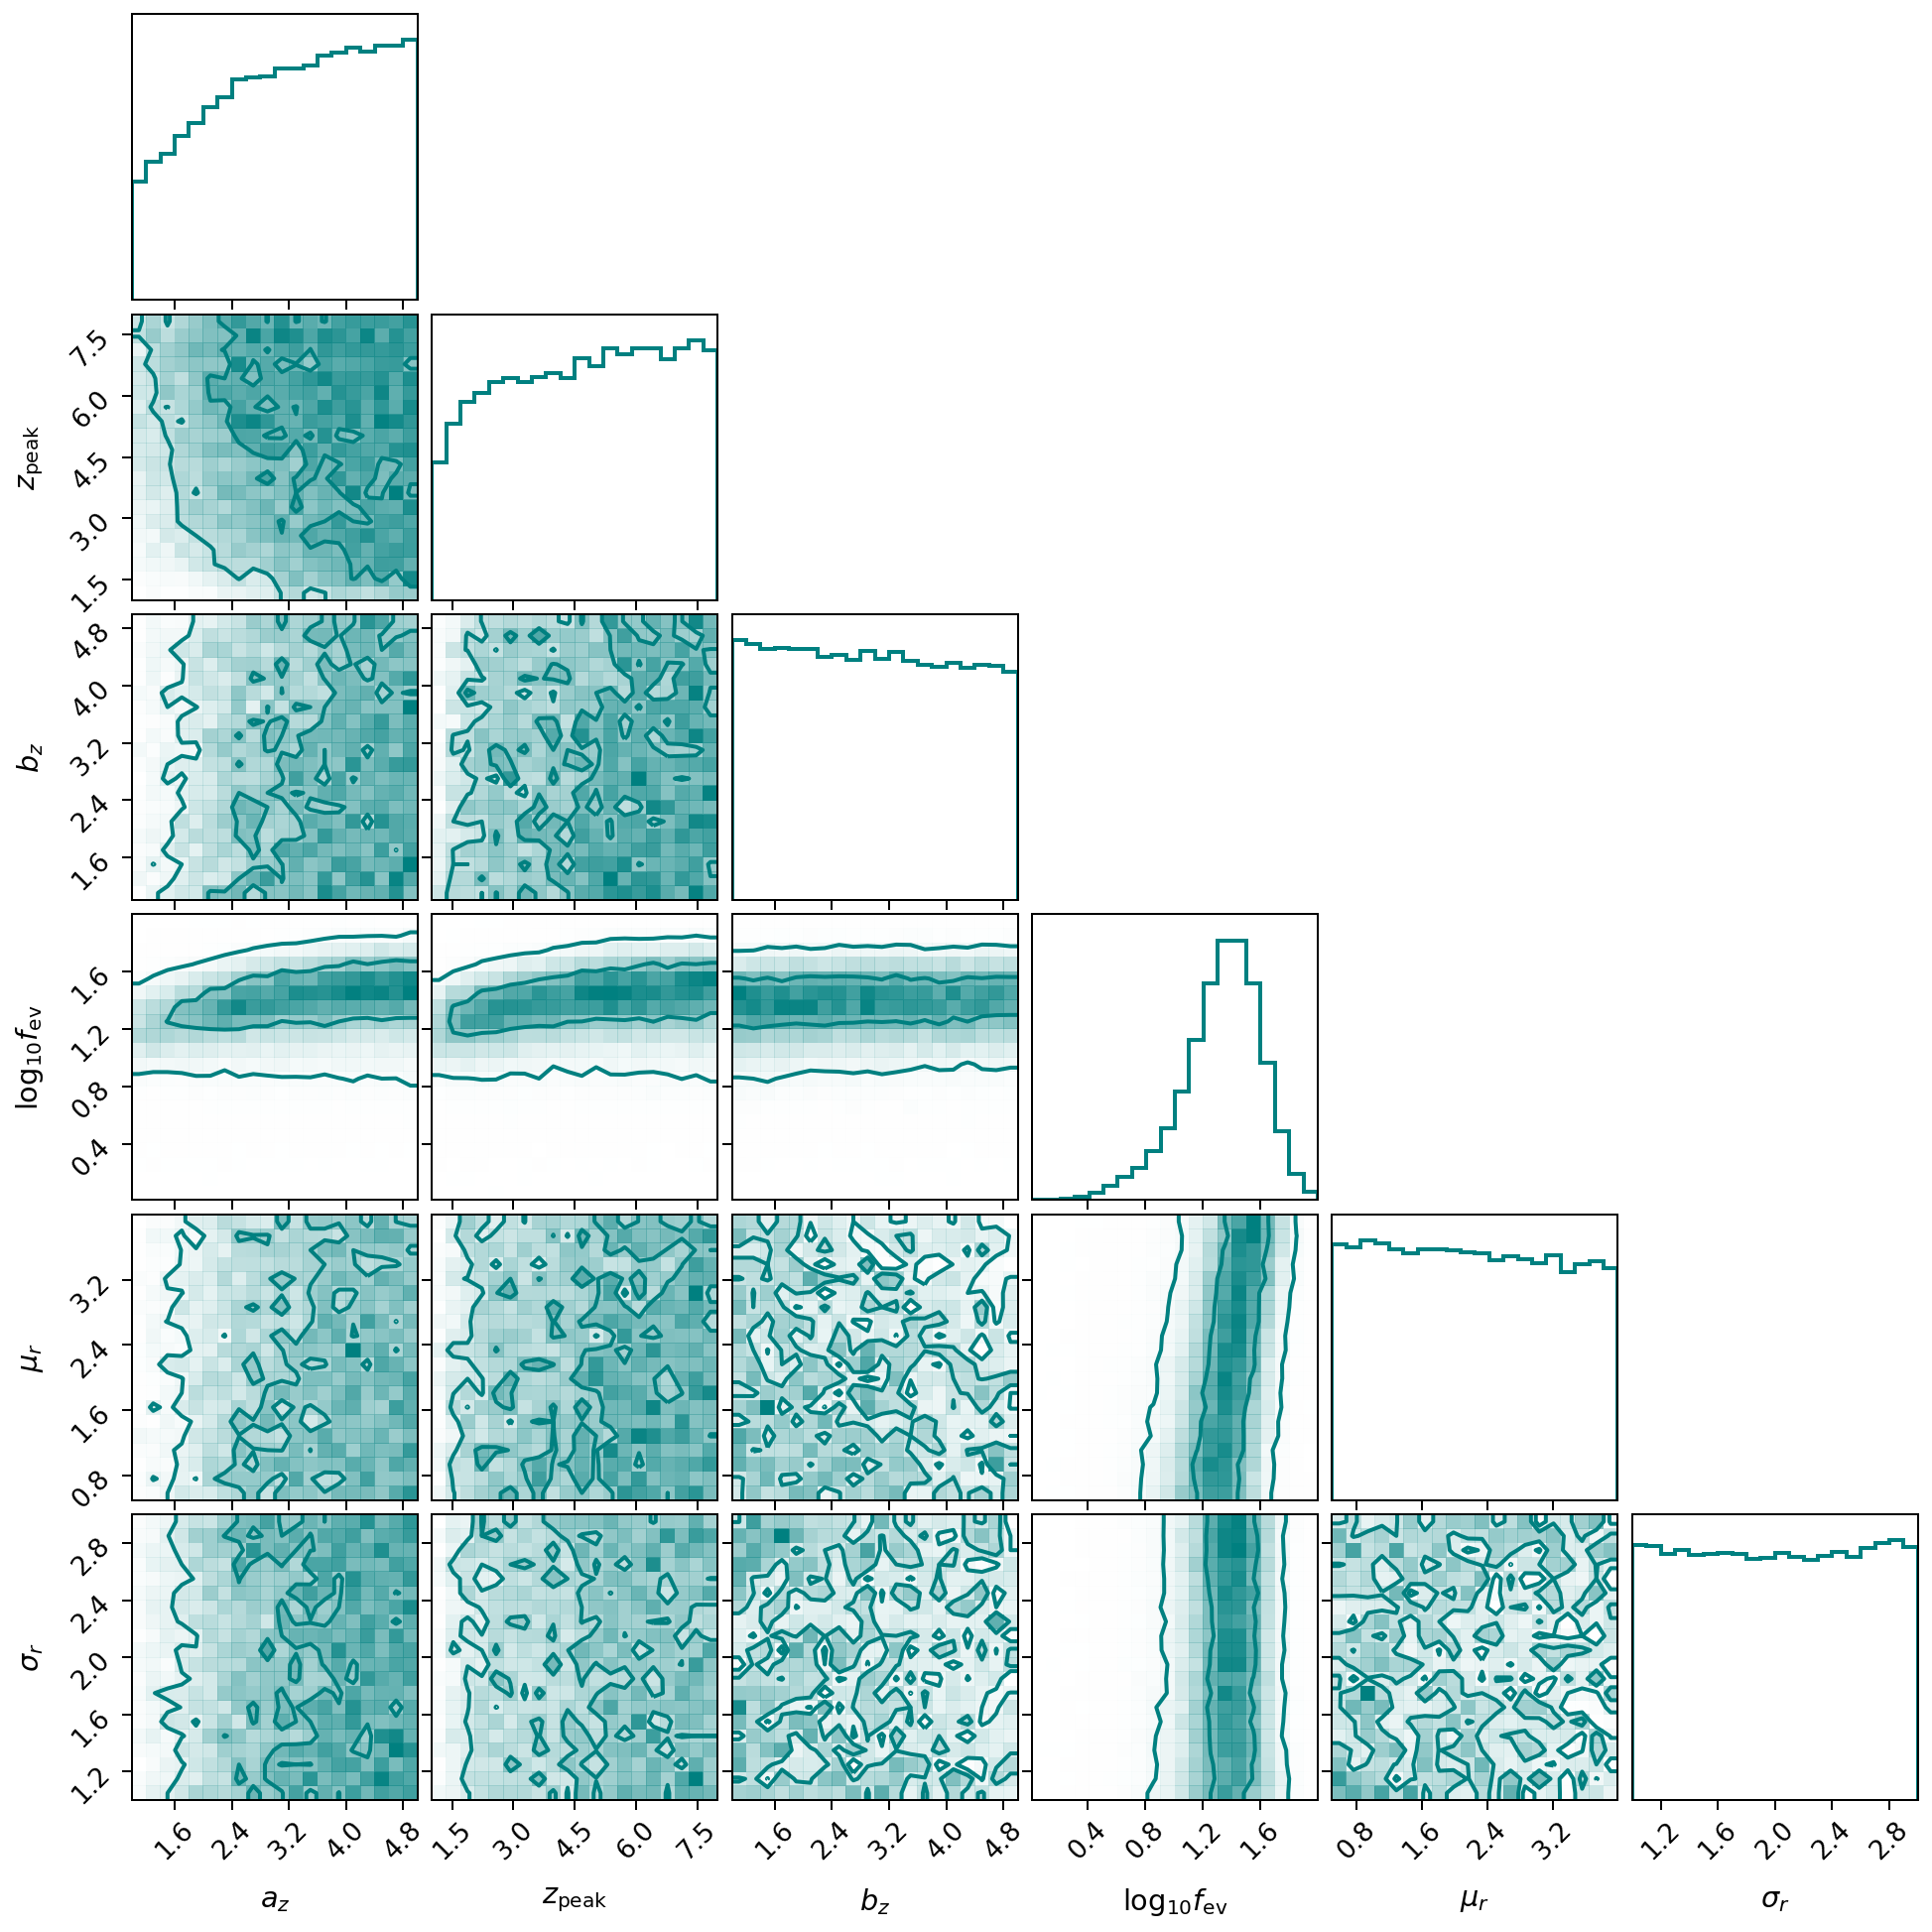

In [85]:
corner.corner(samples, var_names = ['a', 'z_gc', 'b', 'logf_disrupted_cluster', 'mu_rv', 'sigma_rv'], labels = 
             ['$a_z$', '$z_\mathrm{peak}$', '$b_z$', '$\log_{10} f_\mathrm{ev}$', '$\mu_r$', '$\sigma_r$'],
             levels = [0.5, 0.9], plot_datapoints = False, color = 'teal', contour_kwargs = {'linewidths': 2.0},  hist_kwargs = {'linewidth': 2.0});

plt.savefig('GCparams_corner_fixedmassdist.pdf')

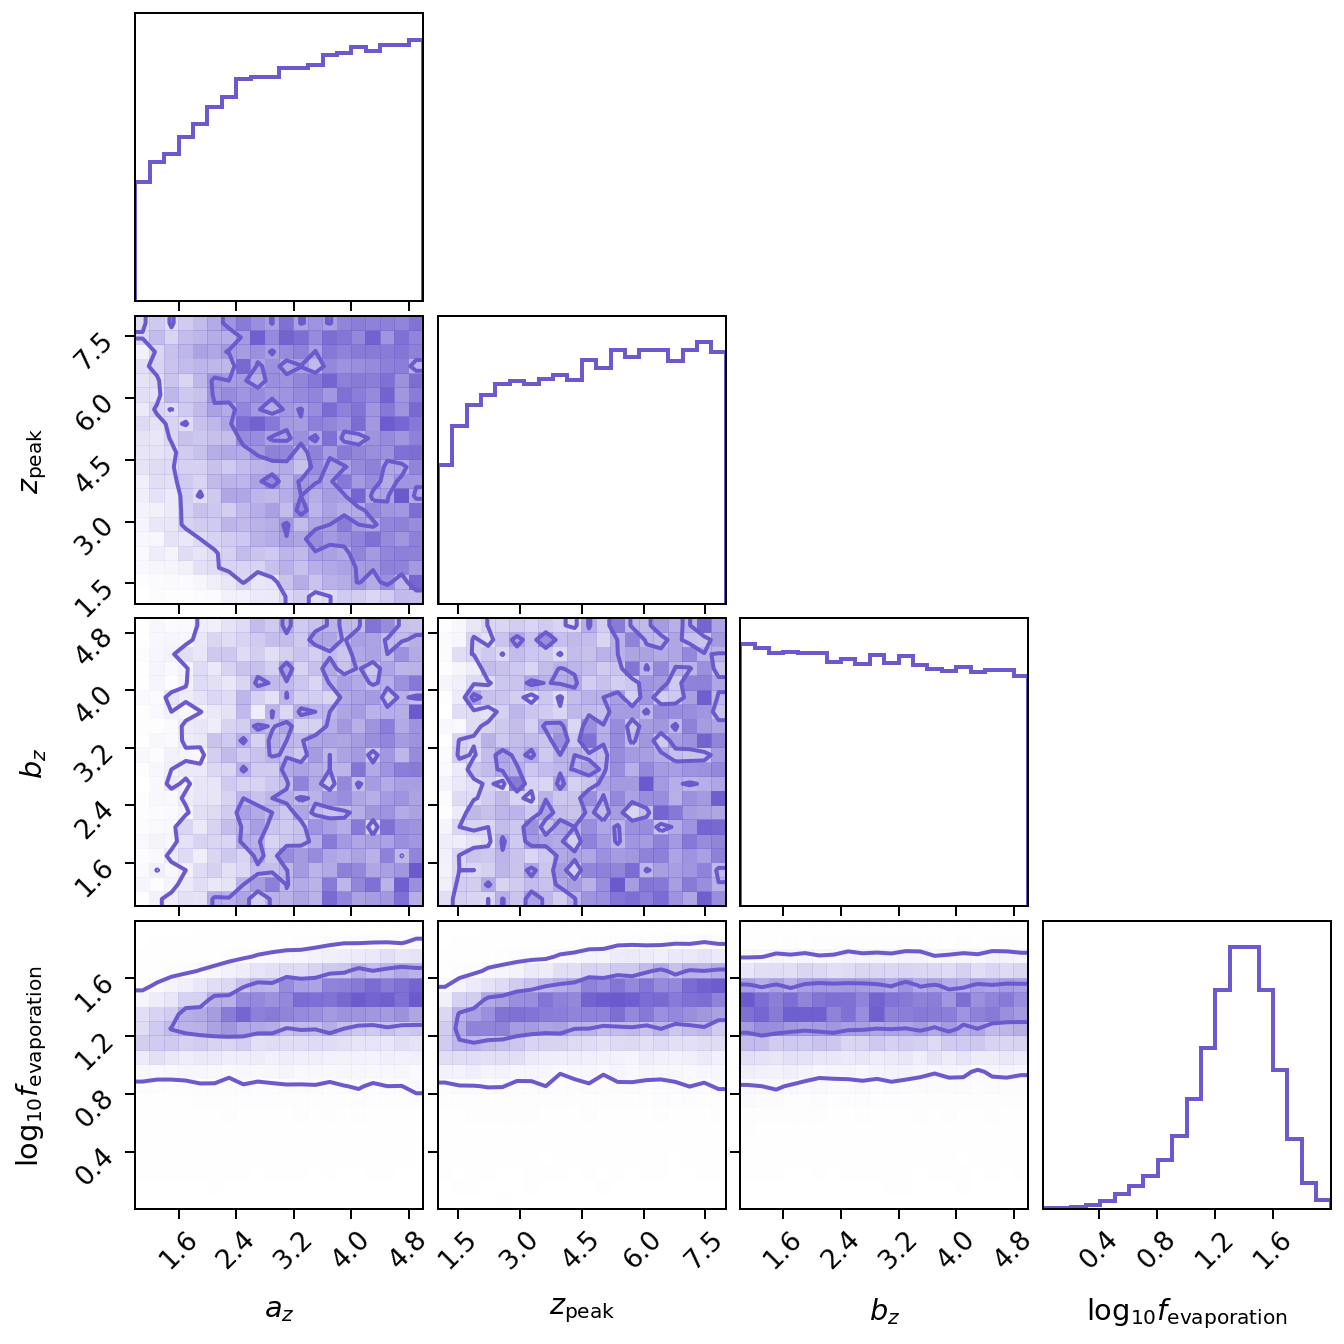

In [29]:
corner.corner(samples, var_names = ['a', 'z_gc', 'b', 'logf_disrupted_cluster'], labels = 
             ['$a_z$', '$z_\mathrm{peak}$', '$b_z$', '$\log_{10} f_\mathrm{evaporation}$'],
             levels = [0.5, 0.9], plot_datapoints = False, color = 'slateblue', contour_kwargs = {'linewidths': 2.0},  hist_kwargs = {'linewidth': 2.0});

plt.savefig('GCparams_corner_fixedmassdist_onlyredshift.pdf')

now the corner plot for the version with the radius distribution fixed, fitting for cluster mass distribution

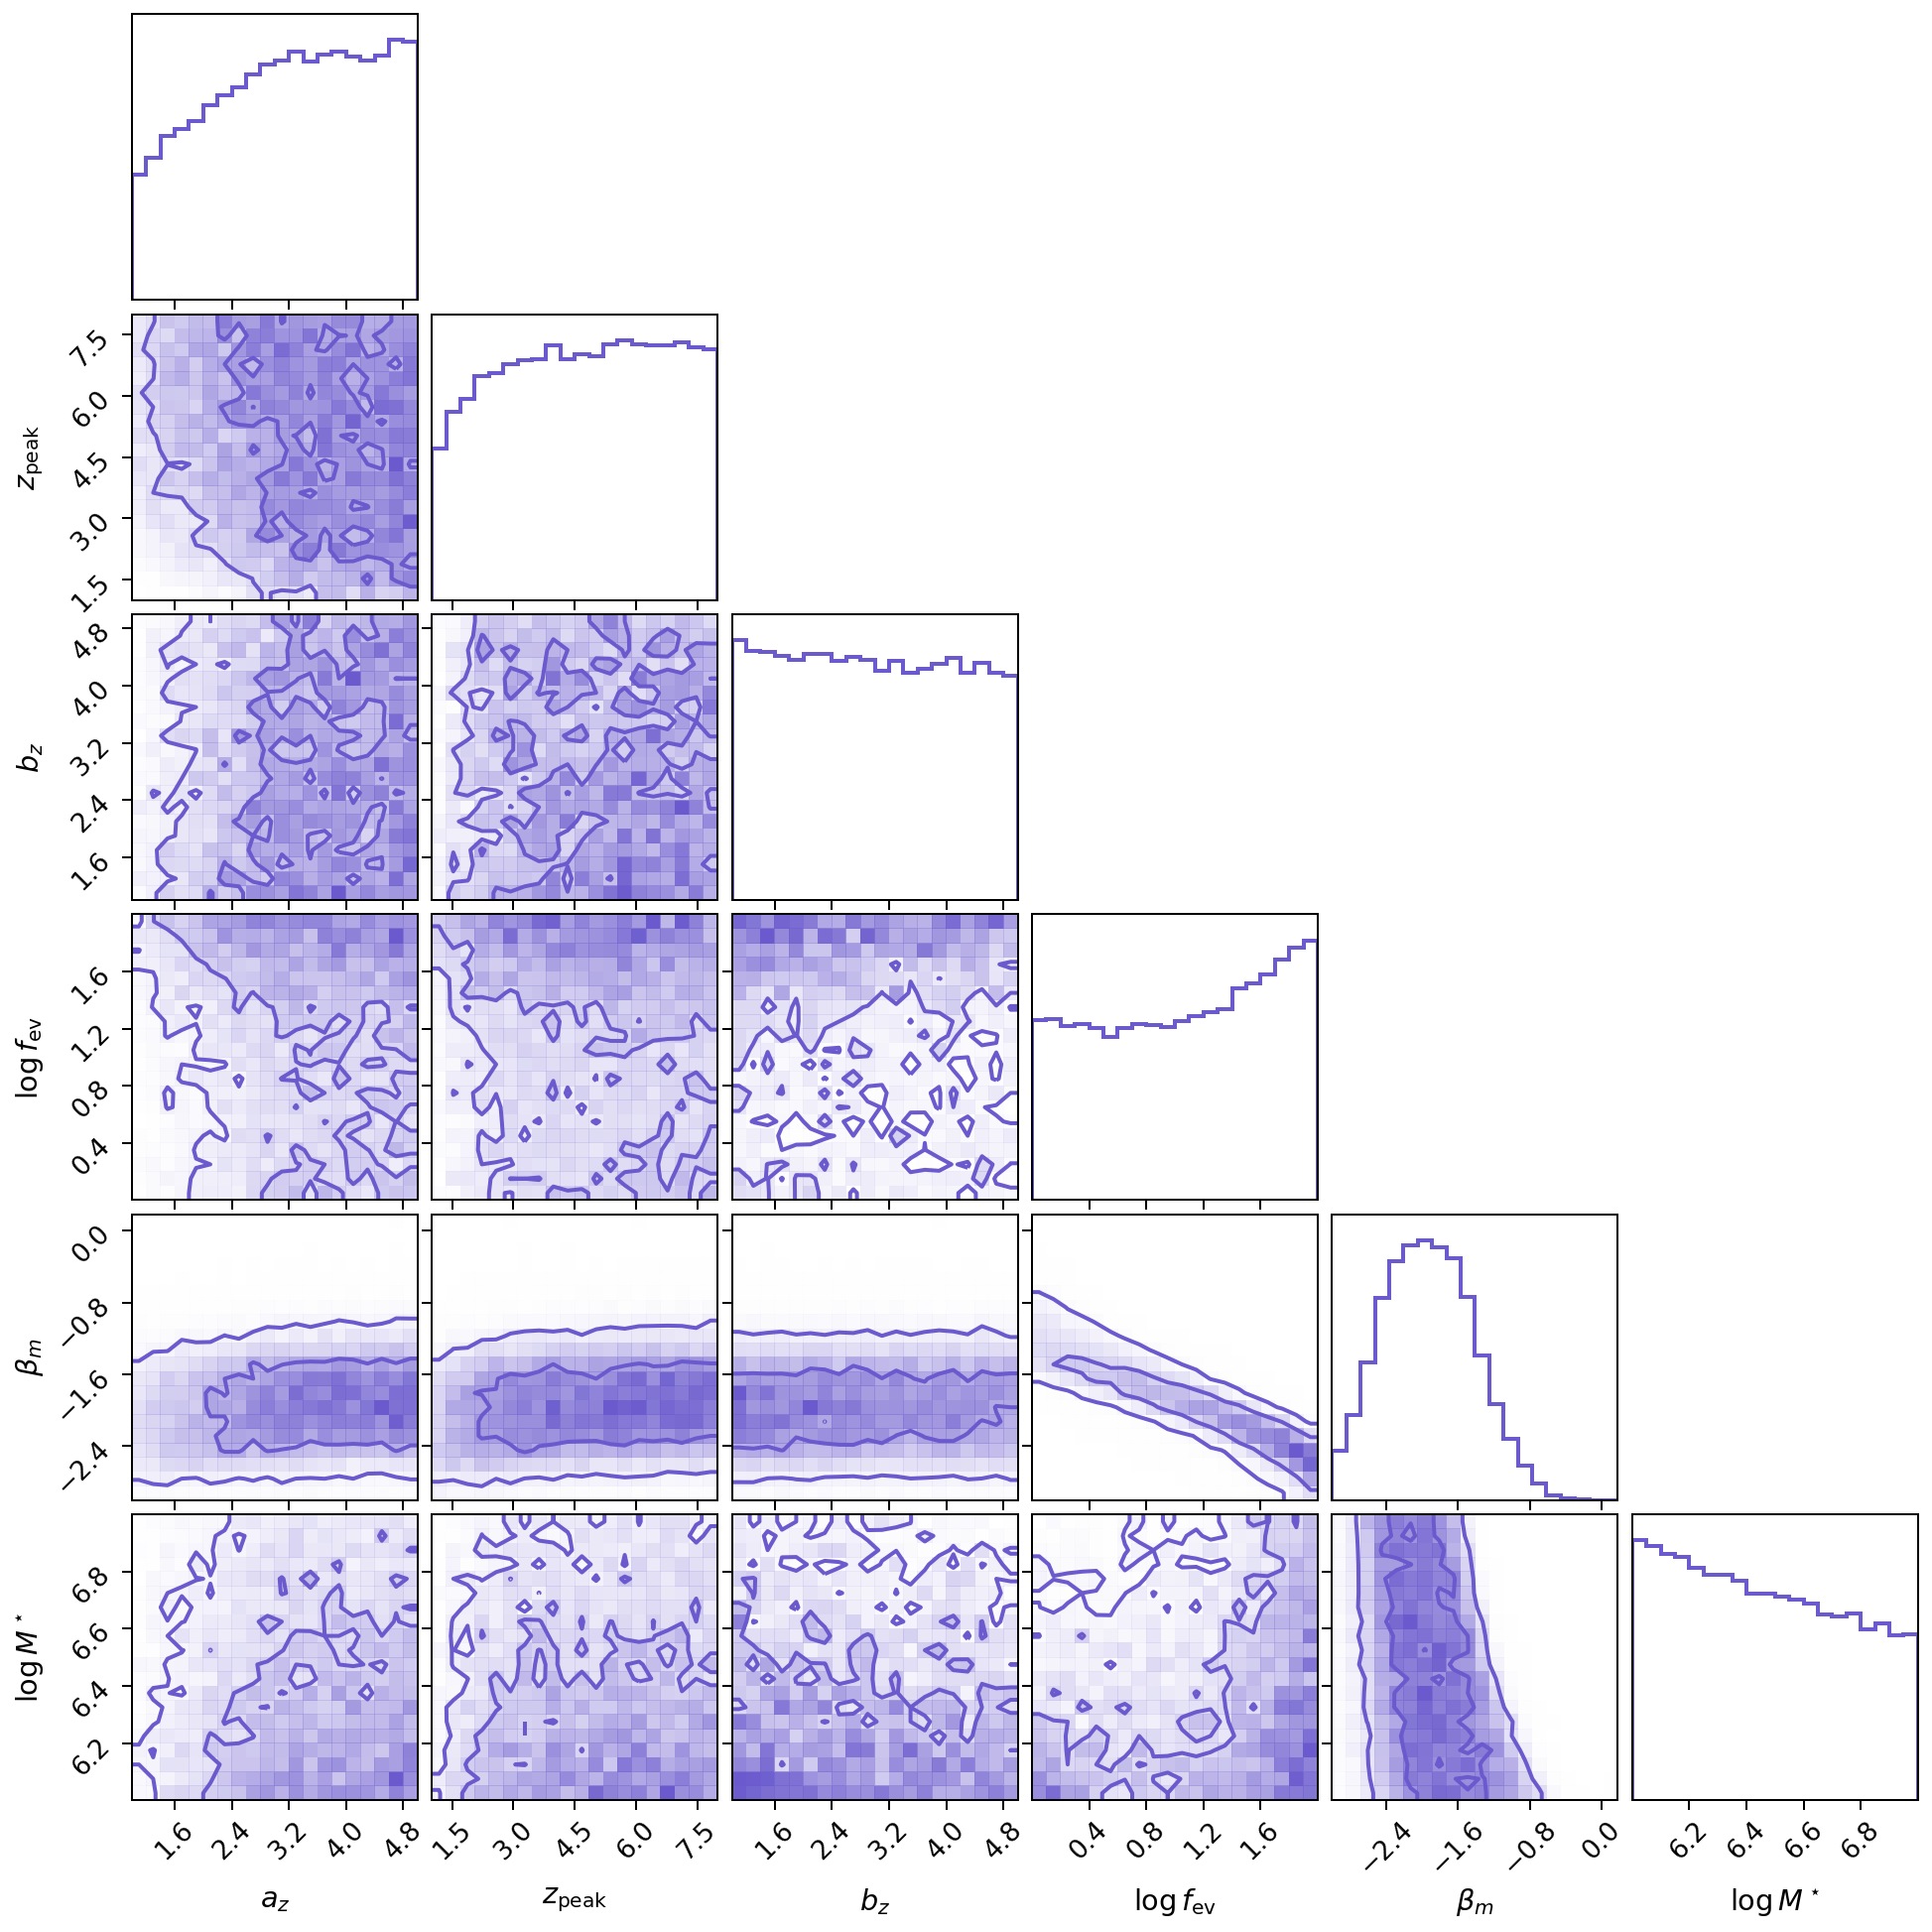

In [86]:
samples_fixedradiusdist = {}
with h5py.File('GC_properties_fixedradiusdist.h5', 'r') as inp:
    for n in inp.keys():
        samples_fixedradiusdist[n] = np.array(inp[n])

corner.corner(samples_fixedradiusdist, var_names = ['a', 'z_gc', 'b', 'logf_disrupted_cluster', 'beta', 'logMstar0'], 
             labels = [r'$a_z$', r'$z_\mathrm{peak}$', r'$b_z$', r'$\log f_\mathrm{ev}$', r'$\beta_m$', r'$\log M^\star$'],
              levels = [0.5, 0.9], plot_datapoints = False, color = 'slateblue', contour_kwargs = {'linewidths': 2.0}, hist_kwargs = {'linewidth': 2.0});

plt.savefig('GCparams_corner_fixedradiusdist.pdf')

Plot the inferred mass distribution

In [77]:
nsamps = 500

logms_model = np.log10(np.array([2e5, 4e5, 8e5, 1.6e6]) * 0.6) #log10mass grid of GC models
dlogm_model = np.diff(logms_model)[0]

logms_total = np.linspace(4,8,200)

p_logmass = np.zeros((len(logms_total), nsamps)) #to store posterior draws of pdf(log10mass)

p_logmass_model = np.zeros((len(logms_model), nsamps))


dNdVdTdlogm_z2 = np.zeros_like(p_logmass) #to store posterior draws of (GC formation density at z = 2) * p(log10mass)

dNdVdTdlogm_z2_model = np.zeros_like(p_logmass_model)


rand_ind = np.random.choice(len(samples['z_gc']), size = nsamps, replace = False)

for j, i in enumerate(rand_ind):
    
    x = 10**(logms_total - samples_fixedradiusdist['logMstar0'][i])
    p_logmass[:, j] = x**(samples_fixedradiusdist['beta'][i] + 1) * np.exp(-x)
    norm = np.trapz(p_logmass[: , j], logms_total)
    p_logmass[:, j] /= norm
    
    x_model = 10**(logms_model - samples_fixedradiusdist['logMstar0'][i])
    p_logmass_model[:,j] = x_model**(samples_fixedradiusdist['beta'][i] + 1) * np.exp(-x_model)
    p_logmass_model[:,j] /= norm
    
    dNdVdT_z2 = GC_rates.sfr_at_z(2, dNdV0, samples_fixedradiusdist['z_gc'][i], samples_fixedradiusdist['a'][i], samples_fixedradiusdist['b'][i], 10**samples_fixedradiusdist['logf_disrupted_cluster'][i])
    dNdVdTdlogm_z2[:, j] = p_logmass[:, j] * dNdVdT_z2
    dNdVdTdlogm_z2_model[:, j] = p_logmass_model[:,j] * dNdVdT_z2

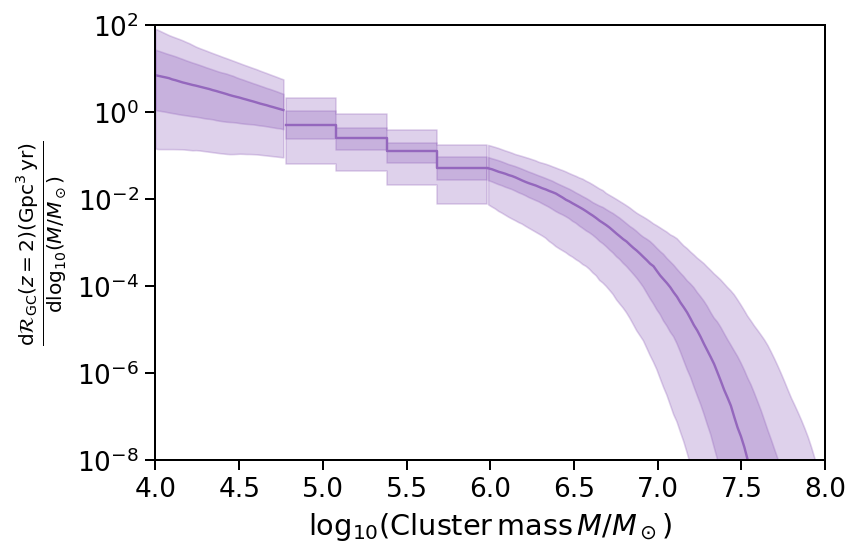

In [87]:
c = sns.color_palette()[4]

logms_model_plot = np.append(logms_model[0] - dlogm_model, logms_model)
plt.step(logms_model_plot, np.append(np.median(dNdVdTdlogm_z2_model, axis = -1)[0], np.median(dNdVdTdlogm_z2_model, axis = -1)), color = c, where = 'pre')
plt.fill_between(logms_model_plot, np.append(np.percentile(dNdVdTdlogm_z2_model, 5, axis = -1)[0], np.percentile(dNdVdTdlogm_z2_model, 5, axis = -1)),
                np.append(np.percentile(dNdVdTdlogm_z2_model, 95, axis = -1)[0], np.percentile(dNdVdTdlogm_z2_model, 95, axis = -1)),
                alpha = 0.3, step = 'pre', color = c)
plt.fill_between(logms_model_plot, np.append(np.percentile(dNdVdTdlogm_z2_model, 25, axis = -1)[0], np.percentile(dNdVdTdlogm_z2_model, 25, axis = -1)),
                np.append(np.percentile(dNdVdTdlogm_z2_model, 75, axis = -1)[0], np.percentile(dNdVdTdlogm_z2_model, 75, axis = -1)),
                alpha = 0.3, step = 'pre', color = c)

sel1 = (logms_total < logms_model_plot[0])
plt.plot(logms_total[sel1] , np.median(dNdVdTdlogm_z2, axis = -1)[sel1], color = c)
plt.fill_between(logms_total[sel1], np.percentile(dNdVdTdlogm_z2, 5, axis = -1)[sel1], np.percentile(dNdVdTdlogm_z2, 95, axis = -1)[sel1], alpha = 0.3, color = c)
plt.fill_between(logms_total[sel1], np.percentile(dNdVdTdlogm_z2, 25, axis = -1)[sel1], np.percentile(dNdVdTdlogm_z2, 75, axis = -1)[sel1], alpha = 0.3, color = c)


sel2 = (logms_total > logms_model_plot[-1])
plt.plot(logms_total[sel2] , np.median(dNdVdTdlogm_z2, axis = -1)[sel2], color = c)
plt.fill_between(logms_total[sel2], np.percentile(dNdVdTdlogm_z2, 5, axis = -1)[sel2], np.percentile(dNdVdTdlogm_z2, 95, axis = -1)[sel2], alpha = 0.3, color = c)
plt.fill_between(logms_total[sel2], np.percentile(dNdVdTdlogm_z2, 25, axis = -1)[sel2], np.percentile(dNdVdTdlogm_z2, 75, axis = -1)[sel2], alpha = 0.3, color = c)

plt.yscale('log')
plt.ylim(1e-8,100)
plt.xlim(4,8)

plt.xlabel(r'$\log_{10}(\mathrm{Cluster\,mass\,} M / M_\odot)$')
plt.ylabel(r'$\frac{\mathrm{d}\mathcal{R}_\mathrm{GC}(z = 2)(\mathrm{Gpc}^3\,\mathrm{yr})}{\mathrm{d}\log_{10}(M / M_\odot)}$')

plt.savefig('GCmass_distribution_posterior.pdf')